In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.17.0


In [3]:
def load_data(datasets):
    """
    datasets: dict of dataset name and its corresponding input data and ground truth
    """
    # For every dataset path in datasets
        # Get the jpg files 
        # Sort them
        # Print "Loaded {dataset}"
        # Assert len(input_paths) == len(labels_paths)
    # Create tensor slies for the input and ground labels
    # Zip them together

    # Python list of all the paths of every input in every dataset
    input_paths = []
    gt_paths = []

    image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
    
    for dataset in datasets:
        print(f"Loading in {dataset} dataset...")
        # Get the input and ground truth paths
        input_dir, gt_dir = datasets[dataset]

        # Get a python list of all the paths of the pictures
        input_path = []
        gt_path = []
        for ext in image_extensions:
            input_path.extend(tf.io.gfile.glob(os.path.join(input_dir, ext)))
            gt_path.extend(tf.io.gfile.glob(os.path.join(gt_dir, ext)))

        # Sort the files so they can be mapped correctly
        input_path = sorted(input_path)
        gt_path = sorted(gt_path)

        # Ensure that their lengths are equal
        assert len(input_path) == len(gt_path) 

        # Print the first input file and its corresponding label for confirmation
        # print(f"Input: {input_path[0]} Label: {gt_path[0]}")

        # Add the paths to input_paths to then zip up the dataset
        input_paths.extend(input_path)
        gt_paths.extend(gt_path)
        
        print("Finished Loading")

    # Create tensor slices of the inputs
    ds_input = tf.data.Dataset.from_tensor_slices(input_paths)
    gt_path  = tf.data.Dataset.from_tensor_slices(gt_paths)

    # Zip up the dataset so that each image has its corresponding label
    ds = tf.data.Dataset.zip(ds_input, gt_path)

    return ds
    

In [4]:
LSUI_data_dir = "/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI"
LSUI_input_dir = f"{LSUI_data_dir}/input"
LSUI_gt_dir = f"{LSUI_data_dir}/GT"

EUVP_UNDERWATER_DARK_data_dir = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_dark"
EUVP_UNDERWATER_DARK_input_dir = f"{EUVP_UNDERWATER_DARK_data_dir}/trainA"
EUVP_UNDERWATER_DARK_gt_dir = f"{EUVP_UNDERWATER_DARK_data_dir}/trainB"

EUVP_UNDERWATER_IMAGENET_data_dir = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet"
EUVP_UNDERWATER_IMAGENET_input_dir = f"{EUVP_UNDERWATER_IMAGENET_data_dir}/trainA"
EUVP_UNDERWATER_IMAGENET_gt_dir = f"{EUVP_UNDERWATER_IMAGENET_data_dir}/trainB"

EUVP_UNDERWATER_SCENES_data_dir = "/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes"
EUVP_UNDERWATER_SCENES_input_dir = f"{EUVP_UNDERWATER_SCENES_data_dir}/trainA"
EUVP_UNDERWATER_SCENES_gt_dir = f"{EUVP_UNDERWATER_SCENES_data_dir}/trainB"

datasets = {
    "LSUI": (LSUI_input_dir, LSUI_gt_dir),
    "EUVP Underwater Dark": (EUVP_UNDERWATER_DARK_input_dir, EUVP_UNDERWATER_DARK_gt_dir),
    "EUVP Underwater ImageNet": (EUVP_UNDERWATER_IMAGENET_input_dir, EUVP_UNDERWATER_IMAGENET_gt_dir)
}

ds = load_data(datasets)

Loading in LSUI dataset...
Finished Loading
Loading in EUVP Underwater Dark dataset...
Finished Loading
Loading in EUVP Underwater ImageNet dataset...
Finished Loading


In [5]:
DATASET_SIZE = len(ds)
print(DATASET_SIZE)

13529


In [6]:
batch_size = 32
img_height = 128
img_width = 128

In [7]:
# Split the dataset into 80% for training and 20% for validation/dev set
val_size = int(DATASET_SIZE * 0.2)
train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)

In [8]:
print(f"Training size: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_ds).numpy()}")

Training size: 10824
Validation size: 2705


In [9]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [10]:
def process_path(input_path, gt_path):
    # Load the raw data from the file as a string
    input_img = tf.io.read_file(input_path)
    gt_img = tf.io.read_file(gt_path)

    input_img = decode_img(input_img)
    gt_img = decode_img(gt_img)
    return input_img, gt_img

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (128, 128, 3)
Label:  (128, 128, 3)


In [13]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [14]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [15]:
# Every batch has 32 images of shape 128x128 and 3 color channels (RGB)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32, 128, 128, 3)


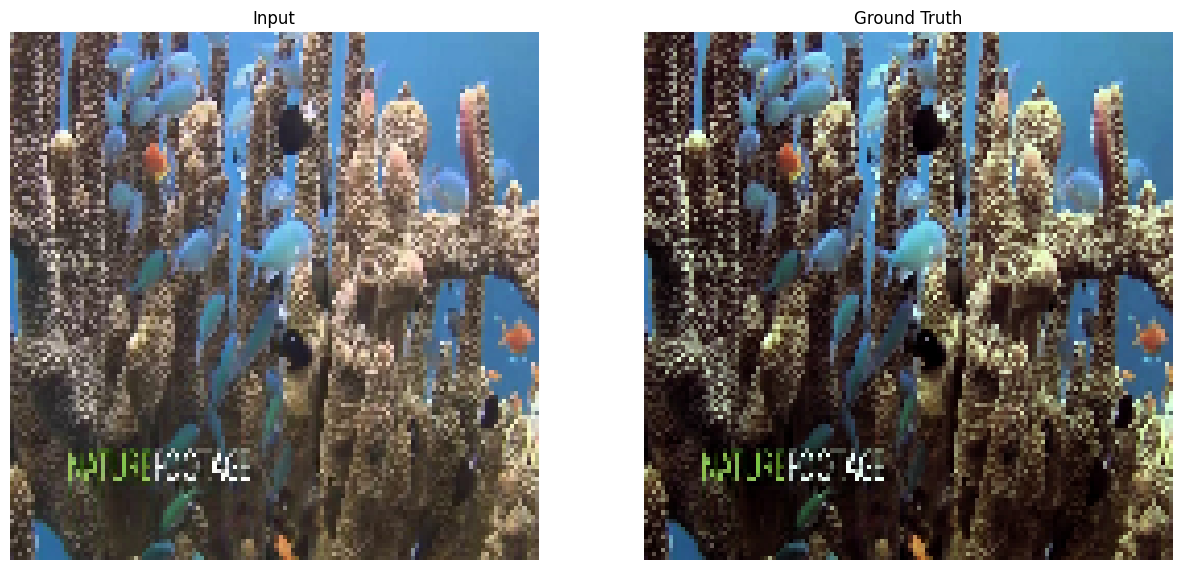

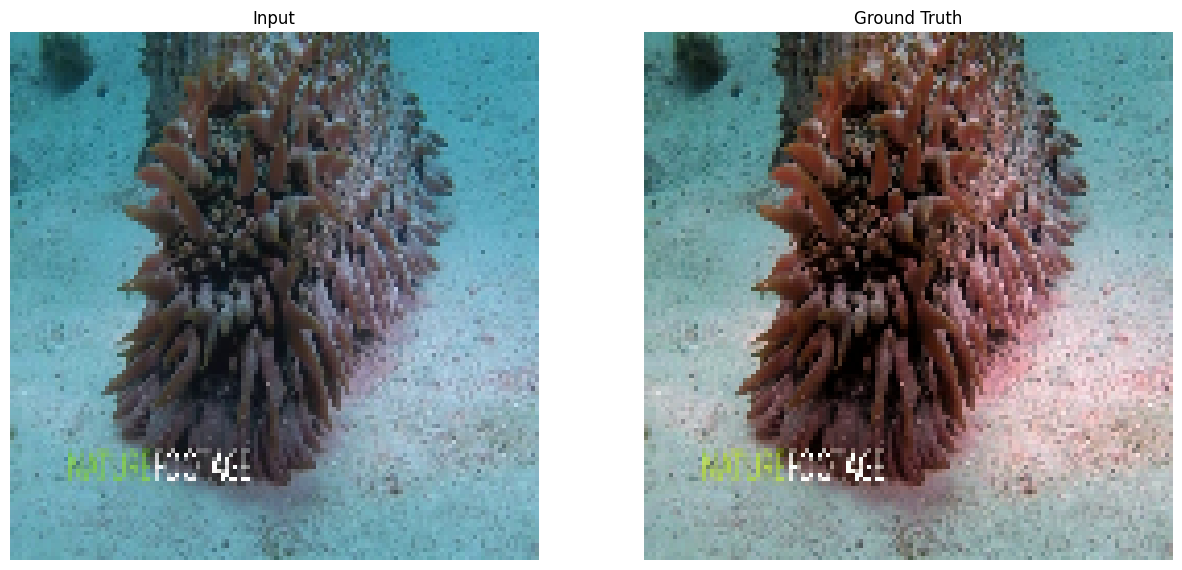

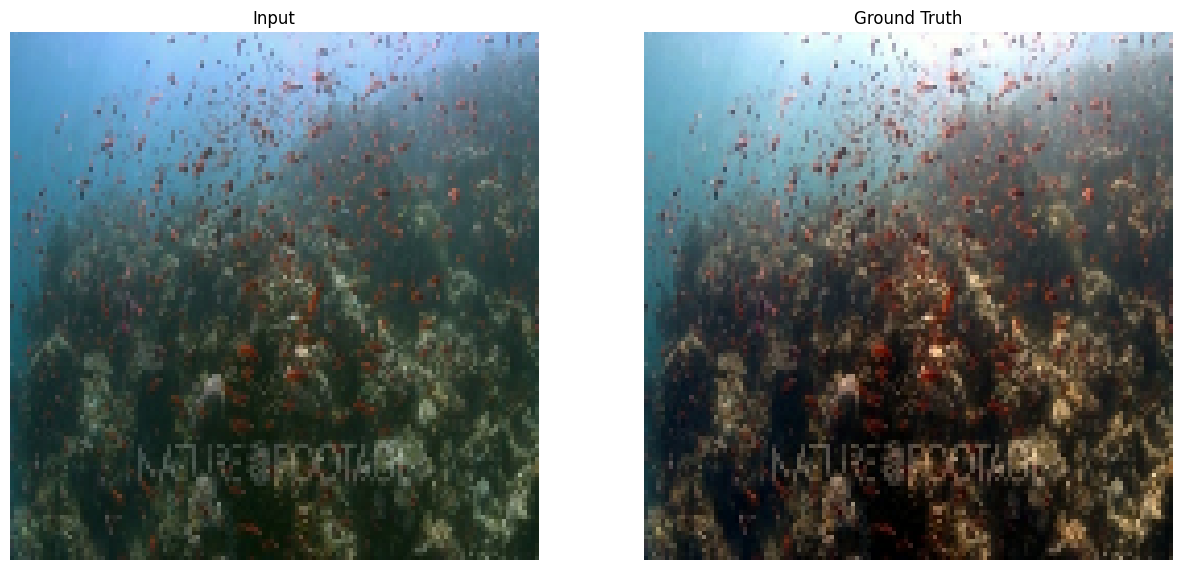

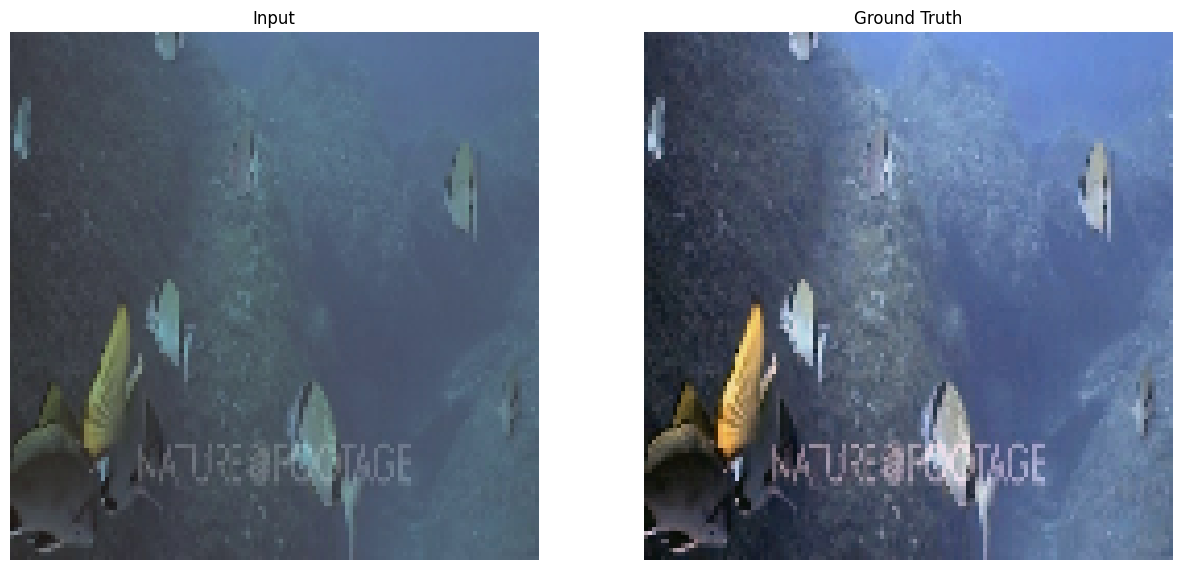

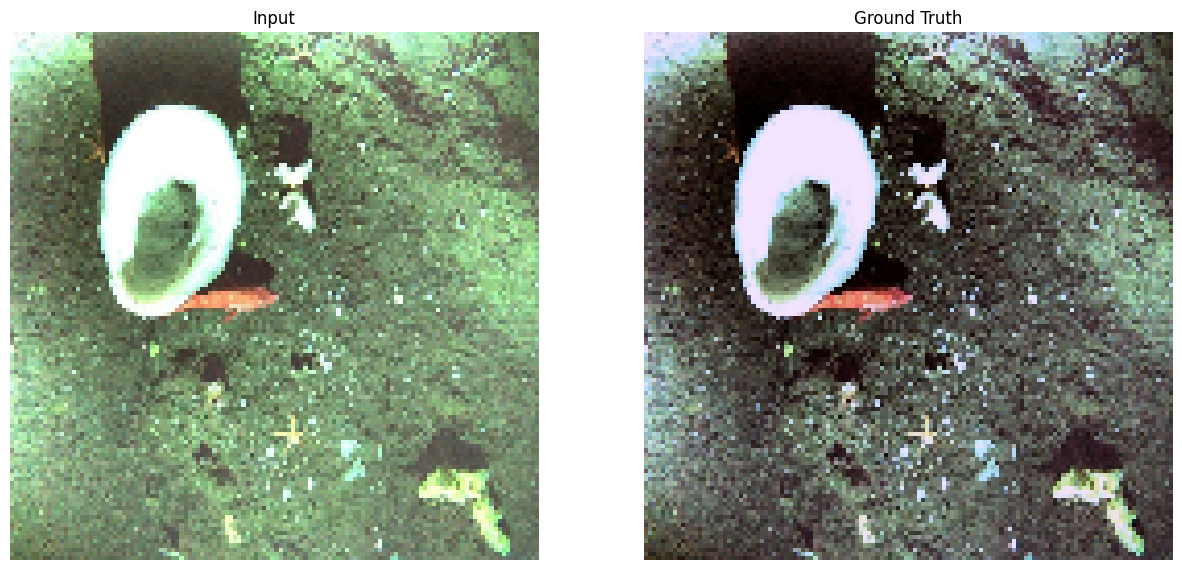

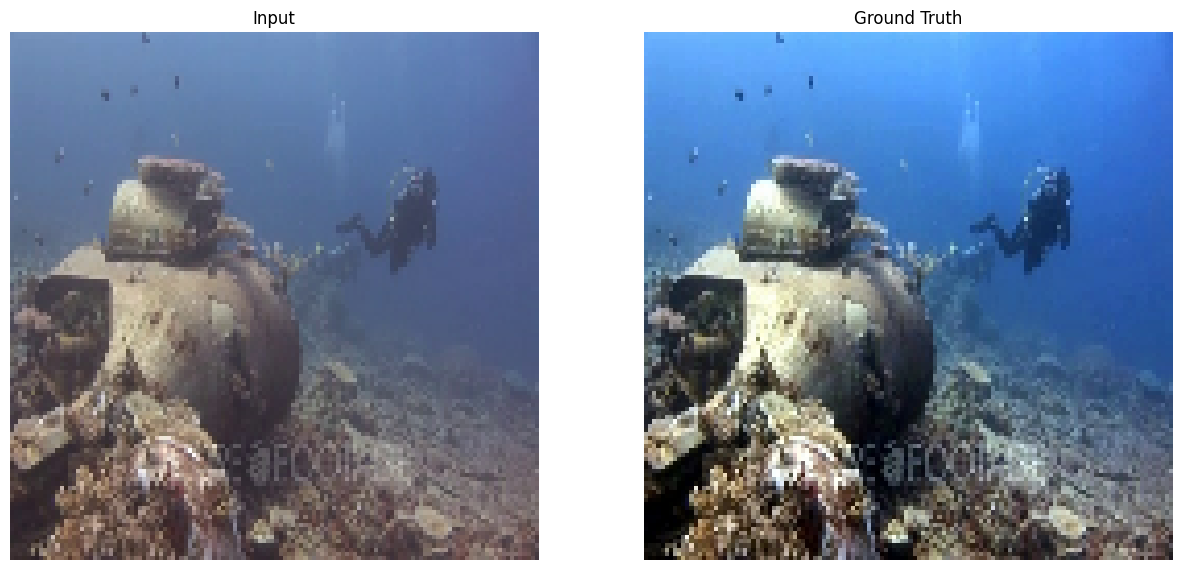

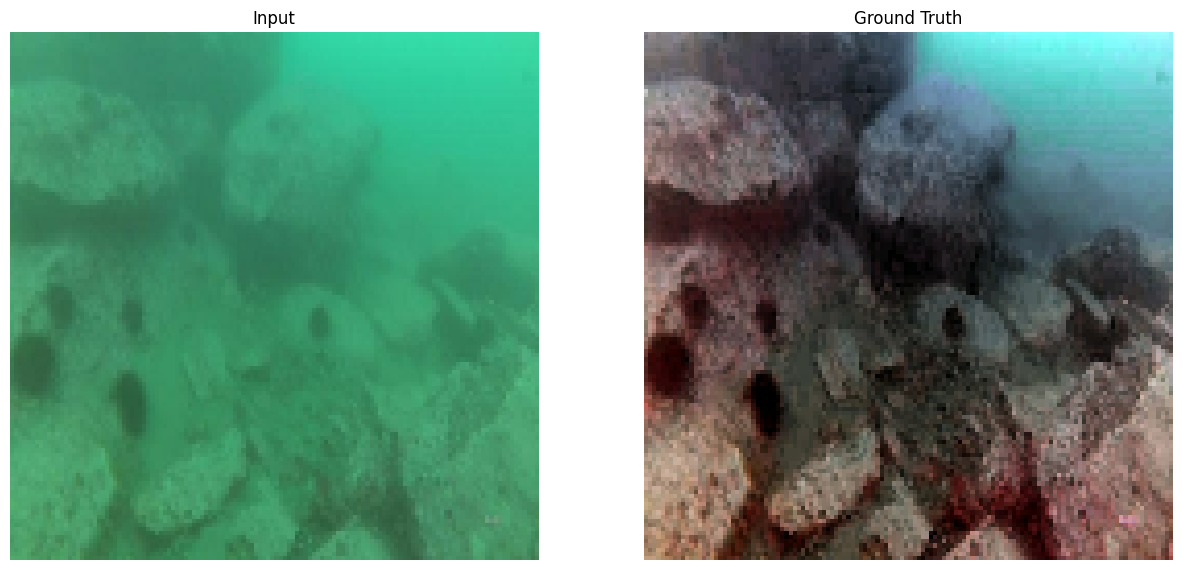

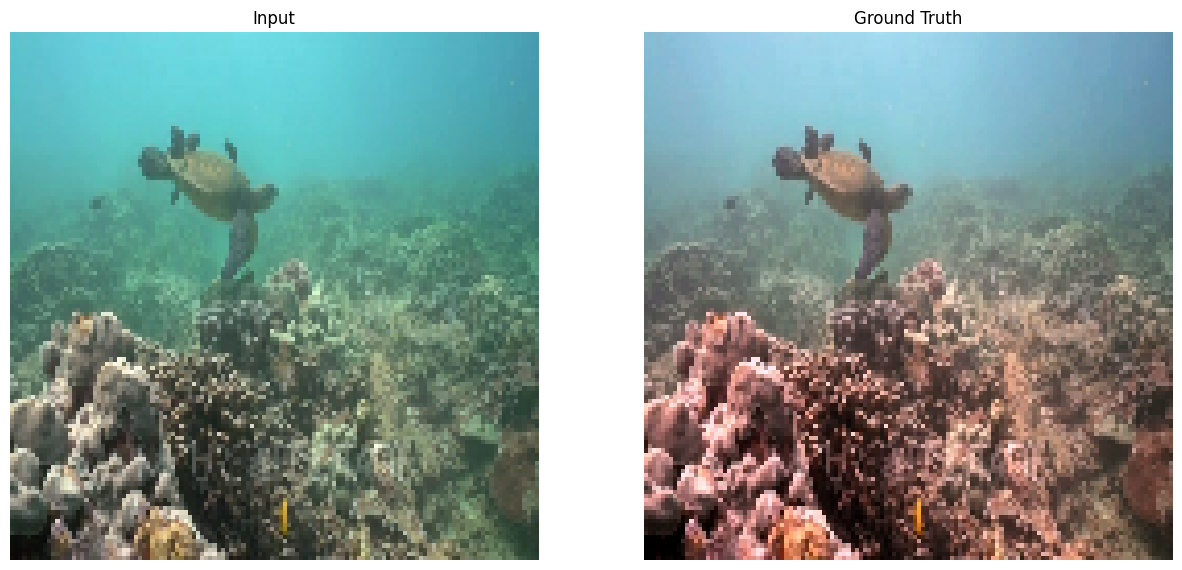

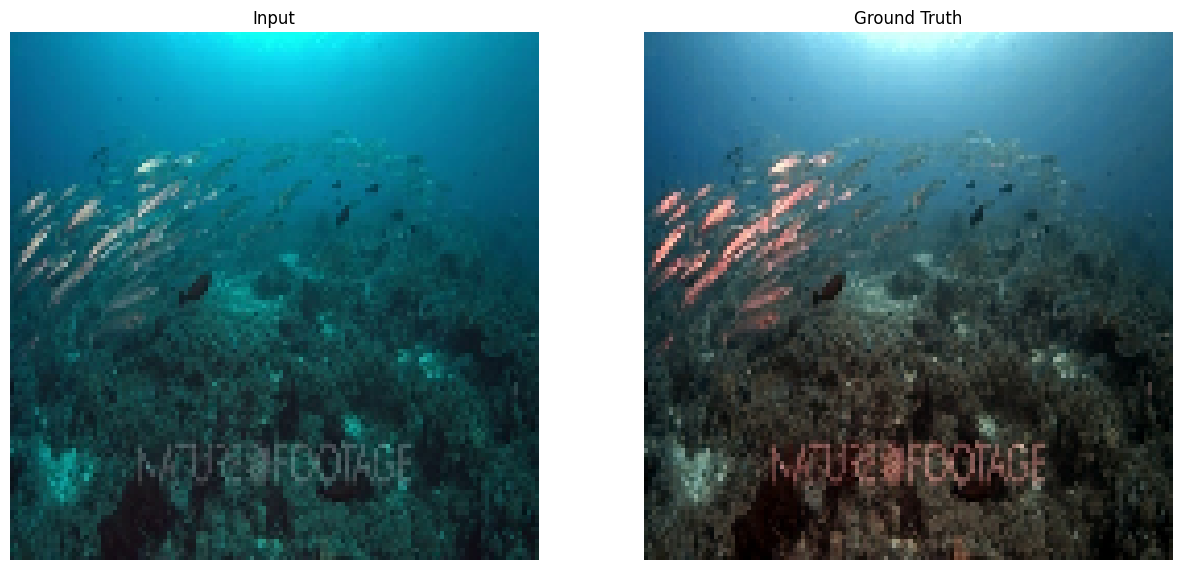

In [16]:
import matplotlib.pyplot as plt

image_batch, gt_batch = next(iter(train_ds))

for i in range(9):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title('Input')
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(gt_batch[i].numpy().astype("uint8"))
    plt.title('Ground Truth')
    plt.axis("off")
    plt.show()